# Аналитика в Яндекс.Афише

### Краткий план действий

- Загрузть и оптимизировать данные о визитах, заказах и расходах

- Построить отчёты и посчитать метрики
    - Продукт:
 1. Сколько людей пользуются в день, неделю, месяц?
 2. Сколько сессий в день?
 3. Сколько длится одна сессия?
 4. Как часто люди возвращаются?
    - Продажи:
 1. Когда люди начинают покупать?
 2. Сколько раз покупают за период?
 3. Какой средний чек?
 4. Сколько денег приносят? (LTV)    
    - Маркетинг:
 1. Сколько денег потратили? Всего / на каждый источник / по времени
 2. Сколько стоило привлечение одного покупателя из каждого источника?
 3. На сколько окупились расходы? (ROI) 
- Отобразить на графиках:
 -  Как метрики отличаются по устройствам
 -  Как метрики меняются во времени

- Общий вывод: рекомендации маркетологам, куда и сколько им стоит вкладывать денег

### Открытие файлов с данными, изучение общей информации

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.options.mode.chained_assignment = None                        
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

### Лог сервера с информацией о посещениях сайта: "visits"

 - Uid — уникальный идентификатор пользователя
 - Device — категория устройства пользователя
 - Start Ts — дата и время начала сессии
 - End Ts — дата и время окончания сессии
 - Source Id — идентификатор рекламного источника, из которого пришел пользователь

### Таблица (информация о заказах): "orders" 

 - Uid — уникальный id пользователя, который сделал заказ
 - Buy Ts — дата и время заказа
 - Revenue — выручка Яндекс.Афиши с этого заказа

### Таблица (информация о затратах на маркетинг): "costs"

 - source_id — идентификатор рекламного источника
 - dt — дата
 - costs — затраты на этот рекламный источник в этот день

In [3]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower()
    display(df.head())
    df.info()

,device,end ts,source id,start ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end ts     359400 non-null  object
 2   source id  359400 non-null  int64 
 3   start ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,buy ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Расмотрев общую информацию по таблицам, видно что нужно отредактировать заголовки таблиц и преобразовать тип данных в колонках с датами.  

In [4]:
# Приведем название столбцов к общему виду
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

In [5]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
# Столбцы с датами приведем к нужному типу datetime
visits['end_ts'], visits['start_ts']  = pd.to_datetime(visits['end_ts']),\
                                        pd.to_datetime(visits['start_ts'])
orders['buy_ts']  = pd.to_datetime(orders['buy_ts'])
costs['dt']  = pd.to_datetime(costs['dt'])

# Продукт

## Посещаемость (день, неделя, месяц)

In [7]:
# Добавим в датафрейм колонки день, неделя, месяц посещения
visits['day_visits'] = visits['start_ts'].astype('datetime64[D]')
visits['week_visits'] = visits['start_ts'].astype('datetime64[W]')
visits['month_visits'] = visits['start_ts'].astype('datetime64[M]')
visits['first_month_y_m'] = visits['month_visits'].dt.strftime('%Y-%m')
visits.head()

,device,end_ts,source_id,start_ts,uid,day_visits,week_visits,month_visits,first_month_y_m
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-12
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-02
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-07
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-05
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-12


In [8]:
# Сгруппируем по дням, неделям и месяцам, 
# посчитаем сумму уникальных посетителей

In [9]:
visits_daily = visits.groupby('day_visits').agg({'uid':'nunique'})
visits_weekly = visits.groupby('week_visits').agg({'uid':'nunique'})
visits_monthly = visits.groupby('first_month_y_m').agg({'uid':'nunique'})

In [10]:
# Построим графики посещаемости сайти
# Создадим функцию plot_visit() построения графиков
def plot_visit(df1, df2, df3, text):
    for series in [df1, df2]:
        series.plot(y='uid', kind='bar', figsize=(16, 4), grid=True, title = text)
        plt.xticks([]) 
        plt.xlabel("Когорты")
        plt.ylabel("Количество посещений")
    df3.plot(y='uid', kind='bar', figsize=(16, 4), grid=True, title = text)
    plt.xlabel("Когорты")
    plt.ylabel("Количество посещений")
    plt.show()

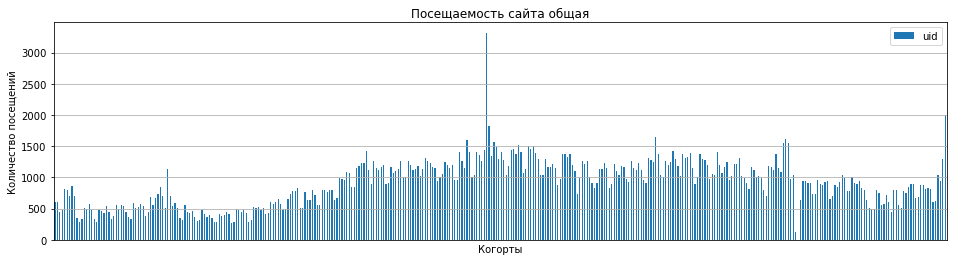

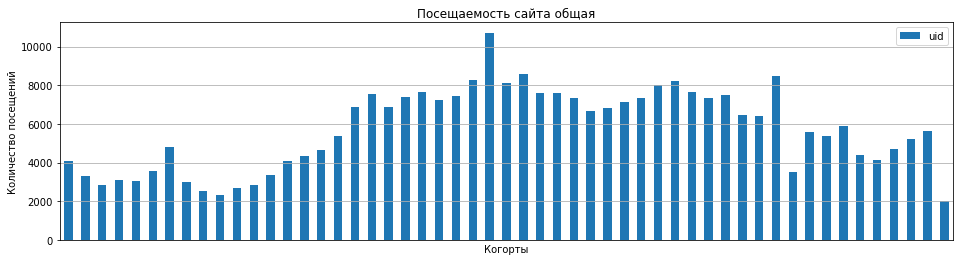

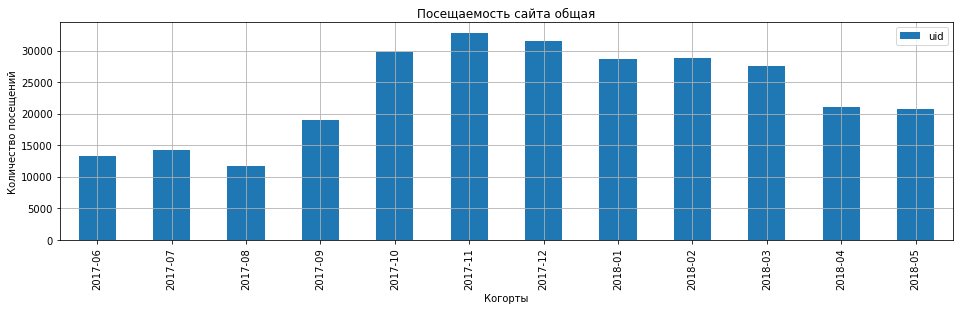

In [11]:
# Вызовем функцию plot_visit() построения графиков
plot_visit(visits_daily,\
           visits_weekly,\
           visits_monthly,\
           'Посещаемость сайта общая')


По графикам видно провалы посещаемости в июне, июле и августе. Начиная с сентября идет рост визитов на сайт. Пик посещаемости приходится на ноябрь месяц, далее начинается плавное ежемесячное снижение количества визитов на сайт.


In [12]:
# Таблица числового описания данных (посещаемости сайта)
def describe_visits(df1, df2, df3):
    pivot_df = df1.describe()
    pivot_df['week'] = df2.describe()
    pivot_df['month'] = df3.describe()
    pivot_df.columns = ['day', 'week', 'month']
    display(pivot_df)

In [13]:
describe_visits(visits_daily, visits_weekly, visits_monthly)

,day,week,month
count,364.00,53.00,12.00
mean,907.99,5724.42,23228.42
std,370.51,2096.12,7546.38
min,1.00,1997.00,11631.00
25%,594.00,4056.00,17777.00
50%,921.00,5894.00,24240.50
75%,1173.00,7441.00,28984.75
max,3319.00,10716.00,32797.00


Из таблицы числового описания данных видно среднее значение посещаемости сайта (уникальных визитов). В день 907 визитов, в неделю 5724 визитов и 23228 визитов в месяц. По стандартоному отклонению видно большой разброс данных. Возможно это связано с сезонностью. Нужно стремится к миниммизации стандартного отклонения числовых данных помесячно, путем увеличения числа визитов в менее посещаемые месяцы (июнь, июль, август).

## Сколько сессий в день

In [14]:
# Посчитаем по дневным группам общее количество посетителей
count_session_day = visits.groupby('day_visits')['uid'].count()
count_session_day.describe()

count    364.00
mean     987.36
std      418.99
min        1.00
25%      635.50
50%     1003.00
75%     1280.00
max     4042.00
Name: uid, dtype: float64

Среднее количество посещений в день равно 987. Это число на 8 % больше от количество уникальных посетителей в день, говорит о том, что некоторые пользователи заходят на сайт по нескольку раз за день. 

## Сколько длится одна сессия

In [15]:
# Найдём ASL — посчитаем длину всех сессий
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [16]:
visits.head()

,device,end_ts,source_id,start_ts,uid,day_visits,week_visits,month_visits,first_month_y_m,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-12,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-02,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-07,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-05,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-12,0


In [17]:
# Построим график распределения продолжительности всех сессий
def session_duration(df):
    df['session_duration_sec'].\
        plot.hist(bins=100,\
                  range=(0, 4000),\
                  title='Распределение продолжительности всех сессий')
    plt.xlabel("Продолжительность сессии")
    plt.ylabel("Количество посещений")

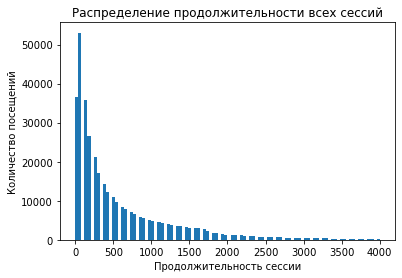

In [18]:
session_duration(visits)

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего)

In [19]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Чаще одна сессия длится 60 секунд. Этого времени скорее всего недостаточно, чтобы совершить покупку.

## Как часто люди возвращаются

In [20]:
# Для каждого клиента получим дату его первой сесии
first_visits_date = visits.groupby('uid')['start_ts'].min()
first_visits_date.name = 'first_visits'
visits = visits.join(first_visits_date, on='uid')
# Выделим месяцы
visits['first_visits_month'] = visits['first_visits'].astype('datetime64[M]')
visits['first_month_y_m'] = visits['first_visits_month'].dt.strftime('%Y-%m')

In [21]:
# Сгруппируем данные по когорте first_visits_month и месяцу визита month_visits
visits_grouped_by_cohorts = visits.\
    groupby(['first_visits_month','month_visits']).\
    agg({'uid':'nunique'})
visits_grouped_by_cohorts.head()

uid
first_visits_month month_visits       
2017-06-01         2017-06-01    13259
                   2017-07-01     1043
                   2017-08-01      713
                   2017-09-01      814
                   2017-10-01      909

In [22]:
# Найдём lifetime когорты. Из visits_month вычтем месяц когорты first_visits_month
visits_grouped_by_cohorts = visits_grouped_by_cohorts.reset_index()
visits_grouped_by_cohorts['cohort_lifetime'] = (
    visits_grouped_by_cohorts['month_visits'] -
    visits_grouped_by_cohorts['first_visits_month']
)
visits_grouped_by_cohorts['cohort_lifetime'] = (
    visits_grouped_by_cohorts['cohort_lifetime'] /
    np.timedelta64(1,'M')
)
visits_grouped_by_cohorts['cohort_lifetime'] = (
    visits_grouped_by_cohorts['cohort_lifetime'].\
    round().astype('int')
)
visits_grouped_by_cohorts['first_visits_month'] = (
    visits_grouped_by_cohorts['first_visits_month'].\
    dt.strftime('%Y-%m')
)
visits_grouped_by_cohorts.head()

,first_visits_month,month_visits,uid,cohort_lifetime
0,2017-06,2017-06-01,13259,0
1,2017-06,2017-07-01,1043,1
2,2017-06,2017-08-01,713,2
3,2017-06,2017-09-01,814,3
4,2017-06,2017-10-01,909,4


In [23]:
# Построим сводную таблицу среднее количество посищений в месяц по когортам
visits_per_user_pivot = visits_grouped_by_cohorts.\
    pivot_table(index='first_visits_month',\
                columns='cohort_lifetime',\
                values='uid',\
                aggfunc='mean')
visits_per_user_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,,
2017-06,13259.00,1043.00,713.00,814.00,909.00,947.00,809.00,766.00,694.00,674.00,539.00,596.00
2017-07,13140.00,737.00,674.00,738.00,765.00,633.00,596.00,601.00,510.00,376.00,361.00,
2017-08,10181.00,783.00,640.00,639.00,510.00,448.00,370.00,402.00,284.00,265.00,,
2017-09,16704.00,1428.00,1156.00,847.00,658.00,632.00,599.00,404.00,381.00,,,
2017-10,25977.00,2042.00,1357.00,1012.00,890.00,837.00,555.00,529.00,,,,
2017-11,27248.00,2133.00,1202.00,1054.00,919.00,638.00,594.00,,,,,
2017-12,25268.00,1410.00,960.00,786.00,512.00,481.00,,,,,,
2018-01,22624.00,1351.00,890.00,565.00,458.00,,,,,,,
2018-02,22197.00,1267.00,565.00,446.00,,,,,,,,


In [24]:
# Чтобы найти Retention Rate, нужно сперва получить число пользователей, 
# изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц
# Найдём исходное количество пользователей в когорте
initial_users_count = visits_grouped_by_cohorts.\
    loc[visits_grouped_by_cohorts['cohort_lifetime'] == 0][['first_visits_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
initial_users_count.head()

,first_visits_month,cohort_users
0,2017-06,13259
12,2017-07,13140
23,2017-08,10181
33,2017-09,16704
42,2017-10,25977


In [25]:
# Объединим данные по когортам с исходным количеством пользователей в когорте:
visits_grouped_by_cohorts = visits_grouped_by_cohorts.\
    merge(initial_users_count, on='first_visits_month')

In [26]:
# Рассчитаем Retention Rate. Разделим количество активных пользователей 
# в каждый из месяцев на исходное число пользователей в когорте
visits_grouped_by_cohorts['retention'] = (
    visits_grouped_by_cohorts['uid'] /
    visits_grouped_by_cohorts['cohort_users']
)
visits_grouped_by_cohorts.head()

,first_visits_month,month_visits,uid,cohort_lifetime,cohort_users,retention
0,2017-06,2017-06-01,13259,0,13259,1.00
1,2017-06,2017-07-01,1043,1,13259,0.08
2,2017-06,2017-08-01,713,2,13259,0.05
3,2017-06,2017-09-01,814,3,13259,0.06
4,2017-06,2017-10-01,909,4,13259,0.07


In [27]:
# Построим сводную таблицу 
retention_pivot = visits_grouped_by_cohorts.\
    pivot_table(index='first_visits_month',\
                columns='cohort_lifetime',\
                values='retention',\
                aggfunc='sum')
retention_pivot.fillna(' ')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,,
2017-06,1.00,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07,1.00,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,
2017-08,1.00,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,,
2017-09,1.00,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,,,
2017-10,1.00,0.08,0.05,0.04,0.03,0.03,0.02,0.02,,,,
2017-11,1.00,0.08,0.04,0.04,0.03,0.02,0.02,,,,,
2017-12,1.00,0.06,0.04,0.03,0.02,0.02,,,,,,
2018-01,1.00,0.06,0.04,0.02,0.02,,,,,,,
2018-02,1.00,0.06,0.03,0.02,,,,,,,,


In [28]:
# Cоздадим тепловую карту удержания
def heatmap_retention_visits(df):
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Как часто люди возвращаются')
    sns.heatmap(df, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1)

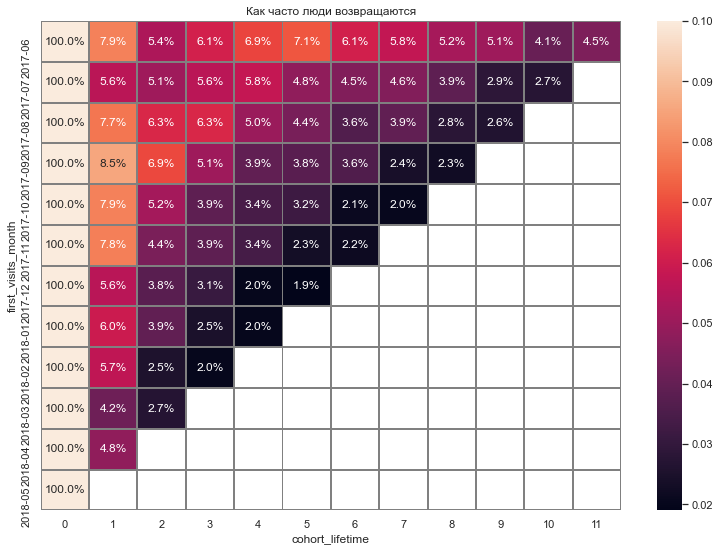

In [29]:
heatmap_retention_visits(retention_pivot)

По июньской когорте видно, что с ноября по апрель посетителей возвращается все меньше и меньше. Подобная динамика оттока повторных визитов наблюдается по всем когортам. Стоит задуматься об удержании клиентов.

# Продажи

## Когда люди начинают покупать

In [30]:
# Пронумеруем по порядку визины 
visits['num_of_session'] = visits.\
    sort_values(['uid','start_ts'], ascending=[True,True]).\
    groupby(['uid']).\
    cumcount() + 1
visits = visits.sort_values(by = ['uid', 'num_of_session'])

# Создадим таблицу визитов и покупок 
session_number = visits[['uid', 'device', 'start_ts', 'end_ts', 'num_of_session']]
session_number = pd.merge(session_number, orders, on='uid')

# Уберем ненужные строки которые не совпадают по времени визита и покупки
session_number = session_number.query('start_ts <= buy_ts <=end_ts')

# Вычислим время между началом сессии и временем покупки
session_number['time_buy'] = session_number['buy_ts'] - session_number['start_ts']
session_number['time_buy'].describe()

count                        35927
mean     0 days 00:09:50.407214629
std      0 days 00:14:25.979253463
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:05:00
75%                0 days 00:12:00
max                0 days 05:26:00
Name: time_buy, dtype: object

В среднем покупают в первые 10 минут после посещения сайта.

 ## Сколько раз покупают за период 

In [31]:
# Убрал значения лишнего 13-го месяца  
orders = orders.query('buy_ts < "2018-06-01"')

# Данные за год. Удобнее всего сформировать месячные когорты. 
# Выделим месяцы из дат в таблице с покупками
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

# Получим месяц первой покупки каждого покупателя
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

# Посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes = first_orders.\
    groupby('first_order_month').\
    agg({'uid': 'nunique'}).\
    reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

# Построим когорты. 
# Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new = pd.merge(orders,first_orders, on='uid')

# Посчитаем количество покупок (coun_buy) за каждый месяц
# Сбросим индекс методом reset_index()
cohorts = orders_new.groupby(['first_order_month','order_month']).\
    agg({'revenue': 'sum', 'uid' : 'count'})
cohorts = cohorts.rename(columns={'uid' : 'coun_buy'})

cohorts['count_buyers'] = orders_new.\
    groupby(['first_order_month', 'order_month']).\
    agg({'uid' : 'nunique'})
cohorts = cohorts.reset_index()

# С точки зрения когортного анализа LTV — накопительная выручка когорты 
# в пересчёте на количество посетителей. 
# Добавим в таблицу cohorts данные о том, 
# сколько посетителей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['mean_count_buy'] = report['coun_buy'] / report['n_buyers']


margin_rate = 1 # Примем по умолчанию  
report['gp'] = report['revenue'] * margin_rate

# Сделаем столбец с возрастом на каждый месяц "жизни" когорты
report['age'] = (
    (report['order_month'] - report['first_order_month']) /
    np.timedelta64(1, 'M')
)
report['age'] = report['age'].round().astype('int')

# Сделаем сводную таблицу среднее количество покупок на одного пользователя в месяц
output_count_buy = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='mean_count_buy', 
        aggfunc='mean').round(2)
    
# Отобразим накопительное количество покупок помесчно на одного пользователя
output_count_buy = output_count_buy.cumsum(axis=1).round(2)
output_count_buy.fillna(' ')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.70,1.84,1.93,2.03,2.11,2.16,2.20
2017-07-01,1.14,1.19,1.25,1.30,1.34,1.38,1.41,1.44,1.47,1.48,1.51,
2017-08-01,1.12,1.20,1.27,1.33,1.39,1.44,1.48,1.54,1.57,1.60,,
2017-09-01,1.14,1.22,1.28,1.34,1.37,1.41,1.45,1.47,1.49,,,
2017-10-01,1.14,1.21,1.25,1.28,1.31,1.33,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.40,1.41,1.43,,,,,
2017-12-01,1.15,1.21,1.26,1.30,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.26,1.28,,,,,,,
2018-02-01,1.12,1.18,1.20,1.22,,,,,,,,


In [32]:
# Посчитаем среднюю сумму покупок одного пользователя за полгода по семи когортам
output_count_buy[5].mean()

1.43

За полгода жизни когорты 1 пользователь совершает в среднем 1.43 покупки

## Какой средний чек

In [33]:
# Посчитаем средний чек помесячно
orders_new['month'] = orders['buy_ts'].dt.strftime('%Y-%m')
mean_check = orders_new.\
    pivot_table(index='uid',\
                columns='month',\
                values='revenue',\
                aggfunc='mean')
mean_check = mean_check.mean()
mean_check

month
2017-06   2.98
2017-07   4.45
2017-08   5.42
2017-09   4.42
2017-10   4.05
2017-11   4.47
2017-12   3.92
2018-01   4.02
2018-02   3.68
2018-03   3.96
2018-04   3.79
2018-05   4.28
dtype: float64

In [34]:
mean_check.describe()

count   12.00
mean     4.12
std      0.58
min      2.98
25%      3.89
50%      4.03
75%      4.43
max      5.42
dtype: float64

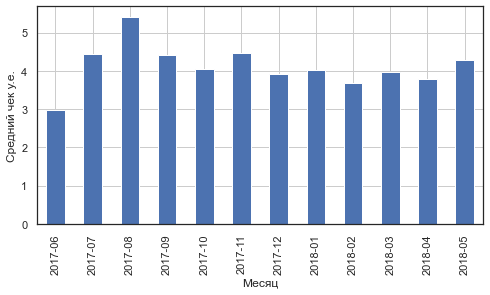

In [35]:
def mean_check_data(df):
    df.plot(y='month', kind='bar', grid=True, figsize=(8, 4))
    plt.xlabel("Месяц")
    plt.ylabel("Средний чек у.е.")
mean_check_data(mean_check)

Средний чек покупателя равен 4.12 у.е. с небольшим стандартным отклонением в 0.58 у.е. Максимальный средний чек возникает в августе, минимальный в июне. Информация для размышления, в конце лета покубают больше, чем в начале. В общем же разброс значений незначительный и близок к среднему, ситуация устойчивая.

## Сколько денег приносят (LTV)

In [36]:
# Наконец, найдём LTV. Разделим валовую прибыль когорт за каждый месяц 
# на общее число пользователей в каждой когорте. 
report['ltv'] = report['gp'] / report['n_buyers']

output_ltv = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)

output_ltv.fillna(' ')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.40,0.20,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.30,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


In [37]:
# Посчитаем накопительный LTV помесячно
output_ltv_6_month = output_ltv.cumsum(axis=1).round(2)
output_ltv_6_month.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.40,
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


In [38]:
output_ltv_6_month[5].mean()

7.97

В среднем каждый покупатель принес по 7.97 у.е. выручки за полгода существования когорты. Видно что сентябрьская когорта самая прибыльная, возможно это связано с ростом числа визитов с сентября по ноябрь месяц.

# Маркетинг

## Сколько денег потратили всего

In [39]:
# Выделим месяцы из дат в таблице с затратами на маркетинг
costs['month'] = costs['dt'].astype('datetime64[M]')

# Сгруппируем расходы помесячно, посчитаем сумму
pivot_costs_month = costs.groupby('month')['costs'].sum().reset_index()

# Сгруппируем покупки помесячно, посчитаем сумму
pivot_revenue_month = orders_new.\
    groupby('order_month')['revenue'].\
    sum().\
    reset_index()
pivot_revenue_month.columns = ['month', 'revenue']

# Соединим две сводные таблицы расходов и покупок
pivot_costs_revenue = pd.merge(pivot_costs_month,\
                               pivot_revenue_month,\
                               on='month')
# Расчитаем прибыль
pivot_costs_revenue['Profit'] = (
    pivot_costs_revenue['revenue'] -
    pivot_costs_revenue['costs']
)
display(pivot_costs_revenue)

print('Расходы за год:', pivot_costs_revenue['costs'].sum().round(2))
print('Доход за год:', pivot_costs_revenue['revenue'].sum().round(2))
print('Прибыль за год:', pivot_costs_revenue['Profit'].sum().round(2))

,month,costs,revenue,Profit
0,2017-06-01,18015.00,9557.49,-8457.51
1,2017-07-01,18240.59,12539.47,-5701.12
2,2017-08-01,14790.54,8758.78,-6031.76
3,2017-09-01,24368.91,18345.51,-6023.40
4,2017-10-01,36322.88,27987.70,-8335.18
5,2017-11-01,37907.88,27069.93,-10837.95
6,2017-12-01,38315.35,36388.60,-1926.75
7,2018-01-01,33518.52,19417.13,-14101.39
8,2018-02-01,32723.03,25560.54,-7162.49
9,2018-03-01,30415.27,28834.59,-1580.68


Расходы за год: 329131.62
Доход за год: 252053.78
Прибыль за год: -77077.84


Даже беглым взглядом видно, что проект на протяжении 2017 года был убыточен. Расходов за год больше на 77077 у.е. чем доходов. Все месяцы были убыточны. Рекламма обходится дороже чем от нее эфект. С ростом расходов на рекламу увеличивается ежемесячный отрицательный балан.

## Сколько денег потратили на каждый источник 

In [40]:
# Посмотрим сколько потрачено денег по рекламным источникам всего
pivot_source_id = costs.groupby('source_id')['costs'].sum().reset_index()
pivot_source_id.sort_values('costs', ascending = False)

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


В общем на третий рекламный источним было потрачено больше всего.

In [41]:
# Сгруппируем помесячно расходы всех рекламных источников
costs_source_id_month = costs.pivot_table(index='month',\
                                          columns='source_id',\
                                          values='costs',\
                                          aggfunc='sum')
costs_source_id_month

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


Text(0, 0.5, 'Расходы')

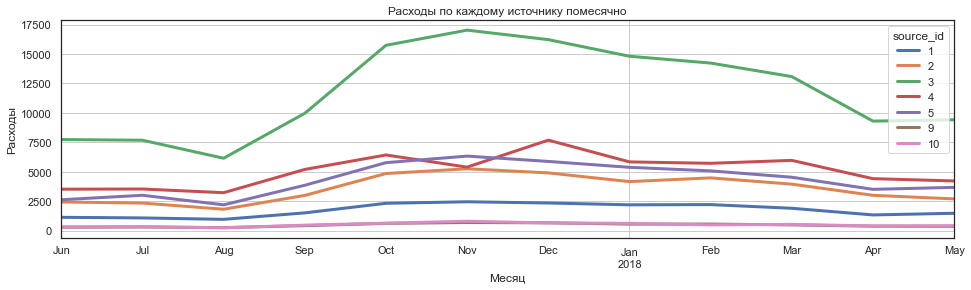

In [42]:
costs_source_id_month.plot(figsize=(16, 4),\
                           grid=True,linewidth = (3),\
                           title= 'Расходы по каждому источнику помесячно',\
                           label=True)
plt.xlabel("Месяц")
plt.ylabel("Расходы")

Наибольшие расходы на рекламу идут по третьему идентификатору рекламмного источника. На графике видно резкое увеличение расходов с августа месяца и по ноябрь. С ноября по январь удержание на высоких отметках, далее плавное снижение затрат. На другие идентификаторы рекламных источников было потрачено напорядок меньше. 

## Сколько стоило привлечение одного покупателя из каждого источника

In [43]:
# Привяжем к каждому идентификатору пользователя идентификатор рекламного источника
# по первой сессии
uid_source_id = visits.groupby('uid')['source_id'].\
                       first().\
                       reset_index()
uid_source_id.head()

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [44]:
# Добавим в таблицу с покупками идентификаторы рекламных источников
orders_new = pd.merge(orders_new, uid_source_id, on='uid')
orders_new.head()

,buy_ts,revenue,uid,order_month,first_order_month,month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06,3


In [45]:
# Найдем количество уникальных покупателей по каждому рекламному источнику
new_cohort_sizes = orders_new.groupby(['first_order_month', 'source_id']).\
    agg({'uid' : 'nunique', 'revenue' : 'sum'}).\
    reset_index()
new_cohort_sizes = new_cohort_sizes.rename(columns={'uid' : 'n_buyers'})
new_cohort_sizes.head()

,first_order_month,source_id,n_buyers,revenue
0,2017-06-01,1,190,6392.39
1,2017-06-01,2,235,3915.26
2,2017-06-01,3,638,3640.32
3,2017-06-01,4,413,4992.67
4,2017-06-01,5,384,4377.64


In [46]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [47]:
cohorts_costs = costs.groupby(['month', 'source_id']).\
    agg({'costs' : 'sum'}).\
    reset_index()

cohorts_costs.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [48]:
report_costs = pd.merge(new_cohort_sizes,\
                        cohorts_costs,\
                        left_on=['first_order_month', 'source_id'],\
                        right_on=['month', 'source_id'])

report_costs['cac'] = report_costs['costs'] / report_costs['n_buyers']
report_costs.head()

,first_order_month,source_id,n_buyers,revenue,month,costs,cac
0,2017-06-01,1,190,6392.39,2017-06-01,1125.61,5.92
1,2017-06-01,2,235,3915.26,2017-06-01,2427.38,10.33
2,2017-06-01,3,638,3640.32,2017-06-01,7731.65,12.12
3,2017-06-01,4,413,4992.67,2017-06-01,3514.80,8.51
4,2017-06-01,5,384,4377.64,2017-06-01,2616.12,6.81


In [49]:
# Средняя стоимость привлечения одного покупателя по источникам
report_costs.groupby('source_id')['cac'].mean().sort_values()

source_id
10    4.87
9     5.41
4     6.44
1     7.21
5     7.45
2    12.50
3    13.80
Name: cac, dtype: float64

Text(0, 0.5, 'Расходы')

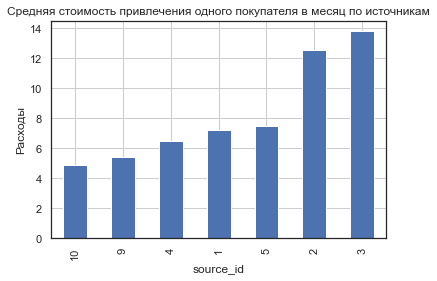

In [50]:
# Построим график "Средняя стоимость привлечения одного покупателя в месяц по источникам"
report_costs.groupby('source_id')['cac'].mean().\
    sort_values().\
    plot.bar(grid=True, \
             title= 'Средняя стоимость привлечения одного покупателя в месяц по источникам')
plt.ylabel("Расходы")

По средней стоимости привлечения одного покупателя в месяц более выгодные три источника: 10, 9 и 4. Самые затратные 3 и 2 рекламные источники. Стоит пересмотреть расходы на рекламу.

In [51]:
# Построим сводную таблицу сас по рекламным источникам ежемесячно
report_costs['month_y_m'] = report_costs['month'].dt.strftime('%Y-%m')
output_cac = report_costs.pivot_table(
        index='month_y_m', 
        columns='source_id', 
        values='cac', 
        aggfunc='mean').round(2)
output_cac    

source_id,1,2,3,4,5,9,10
month_y_m,,,,,,,
2017-06,5.92,10.33,12.12,8.51,6.81,4.19,3.31
2017-07,6.71,11.22,14.99,6.83,7.09,5.82,6.47
2017-08,8.42,14.72,18.23,9.52,6.07,4.08,6.29
2017-09,6.62,13.51,12.76,8.80,6.54,4.78,5.36
2017-10,6.81,12.23,13.66,5.48,6.10,4.84,3.00
2017-11,7.55,13.19,14.00,4.58,9.13,4.71,6.19
2017-12,7.07,12.86,12.32,5.58,7.62,5.44,7.60
2018-01,9.19,14.24,14.72,5.65,8.49,6.84,6.68
2018-02,8.02,15.27,13.03,5.16,7.48,6.57,3.91


Text(0, 0.5, 'Расходы')

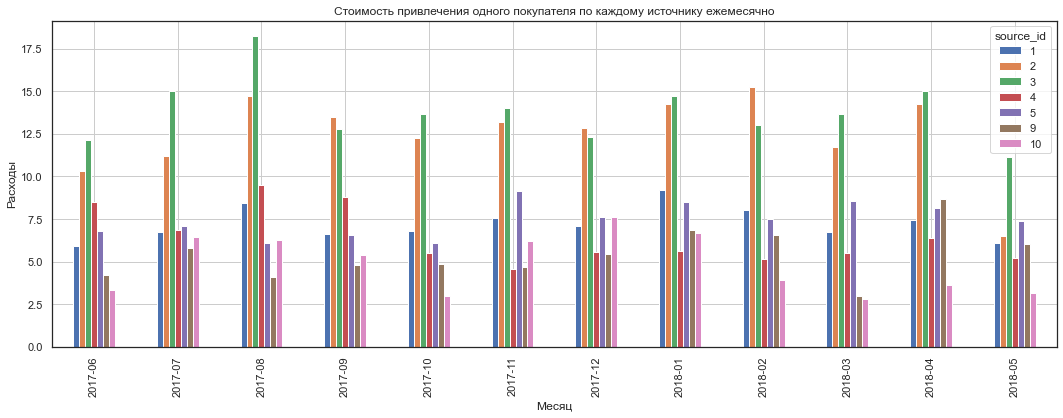

In [52]:
# Построим общую таблицу "Стоимость привлечения одного покупателя по каждому источнику ежемесячно" 
output_cac.plot.bar(figsize=(18, 6),\
                    grid=True,\
                    title= 'Стоимость привлечения одного покупателя по каждому источнику ежемесячно')

plt.xlabel("Месяц")
plt.ylabel("Расходы")

Из таблицы видно, что третий и второй источники наиболее затратные на протяжении всего года рекламной компании.

## На сколько окупились расходы (ROI)

In [53]:
# Расчитаем необходимые метрики
report_costs['ltv'] = report_costs['revenue'] / report_costs['n_buyers']
report_costs['roi'] = (report_costs['revenue'] - report_costs['costs']) / report_costs['costs']
report_costs.head()

,first_order_month,source_id,n_buyers,revenue,month,costs,cac,month_y_m,ltv,roi
0,2017-06-01,1,190,6392.39,2017-06-01,1125.61,5.92,2017-06,33.64,4.68
1,2017-06-01,2,235,3915.26,2017-06-01,2427.38,10.33,2017-06,16.66,0.61
2,2017-06-01,3,638,3640.32,2017-06-01,7731.65,12.12,2017-06,5.71,-0.53
3,2017-06-01,4,413,4992.67,2017-06-01,3514.80,8.51,2017-06,12.09,0.42
4,2017-06-01,5,384,4377.64,2017-06-01,2616.12,6.81,2017-06,11.40,0.67


In [54]:
# Сгруппируем roi по идентификатору рекламного источника и месяцу
output_roi = report_costs.pivot_table(
        index='source_id', 
        columns='month_y_m', 
        values='roi', 
        aggfunc='mean')
output_roi

month_y_m,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,4.68,2.12,1.22,0.57,0.23,0.35,-0.22,-0.24,-0.24,0.79,-0.33,-0.14
2,0.61,0.01,-0.44,0.98,0.02,-0.26,1.88,-0.46,-0.56,-0.38,-0.56,0.05
3,-0.53,-0.51,-0.66,-0.46,-0.58,-0.64,-0.62,-0.69,-0.67,-0.65,-0.60,-0.65
4,0.42,-0.08,-0.32,-0.12,-0.06,0.48,-0.18,-0.28,-0.18,-0.14,-0.19,-0.10
5,0.67,-0.04,0.67,3.00,-0.01,-0.43,-0.30,-0.37,-0.40,-0.43,-0.48,-0.43
9,0.66,0.21,0.45,1.02,0.45,-0.04,-0.13,-0.52,-0.23,-0.07,-0.35,-0.38
10,-0.23,-0.44,-0.10,-0.51,-0.05,-0.18,-0.48,-0.52,-0.34,0.25,-0.33,0.15


In [55]:
# Посчитаем накопительный ROMI
output_roi.cumsum(axis=1).round(2)

month_y_m,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,4.68,6.79,8.01,8.59,8.82,9.17,8.95,8.72,8.48,9.27,8.94,8.80
2,0.61,0.62,0.19,1.16,1.19,0.92,2.81,2.35,1.78,1.41,0.84,0.89
3,-0.53,-1.04,-1.70,-2.16,-2.74,-3.39,-4.00,-4.69,-5.37,-6.02,-6.62,-7.27
4,0.42,0.34,0.02,-0.10,-0.17,0.31,0.13,-0.15,-0.32,-0.46,-0.65,-0.75
5,0.67,0.63,1.30,4.30,4.29,3.86,3.56,3.19,2.78,2.35,1.88,1.45
9,0.66,0.87,1.32,2.34,2.79,2.75,2.63,2.11,1.88,1.81,1.46,1.08
10,-0.23,-0.67,-0.77,-1.28,-1.33,-1.51,-1.98,-2.50,-2.84,-2.59,-2.92,-2.77


Первый, второй, пятый и девятый рекламные источники окупились с первого месяца наблюдения и продолжали приносить прибыль на протяжении всего года. Третий и десятый рекламные источники были весь год убыточные. Четвертый оказался убыточный по результатам наблюдения на конец года.

In [56]:
# Узнаем, как быстро в среднем когорты окупаются. 
# Усредним значения каждой колонки и сложим таблицу в единую строку
output_roi.cumsum(axis=1).mean(axis=0)

month_y_m
2017-06   0.90
2017-07   1.08
2017-08   1.20
2017-09   1.84
2017-10   1.84
2017-11   1.73
2017-12   1.73
2018-01   1.29
2018-02   0.91
2018-03   0.83
2018-04   0.42
2018-05   0.20
dtype: float64

Если рассматривать эффективность рекламных источников вместе взятых, то они в целом убыточны. Необходимо снизить расходы на 3, 4 и 10 рекламные источники, и напротив же повысить расходы на 1, 2, 5 и  9 рекламные источники.

# Метрики по устройствам

## Посещаемость по устройствам (день, неделя, месяц)¶

In [57]:
# Сделаем таблицы визитов по устройствам desktop и touch
visits_desktop = visits.query('device == "desktop"')
visits_touch = visits.query('device == "touch"')

### desktop

In [58]:
# Сформируем когорты по дням, неделям и месяцам

visits_daily_desktop_user = visits_desktop.groupby('day_visits').agg({'uid':'nunique'})
visits_weekly_desktop_user = visits_desktop.groupby('week_visits').agg({'uid':'nunique'})
visits_monthly_desktop_user = visits_desktop.groupby('first_month_y_m').agg({'uid':'nunique'})

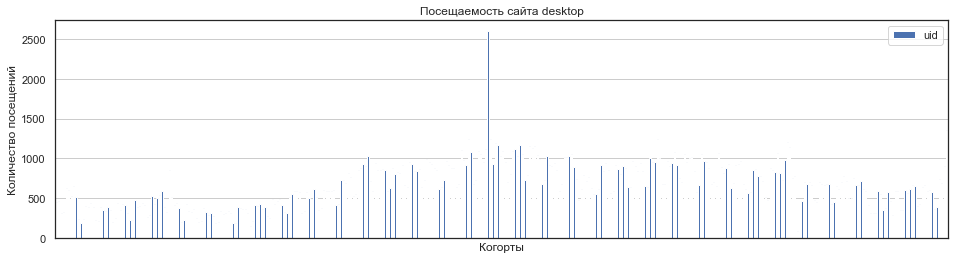

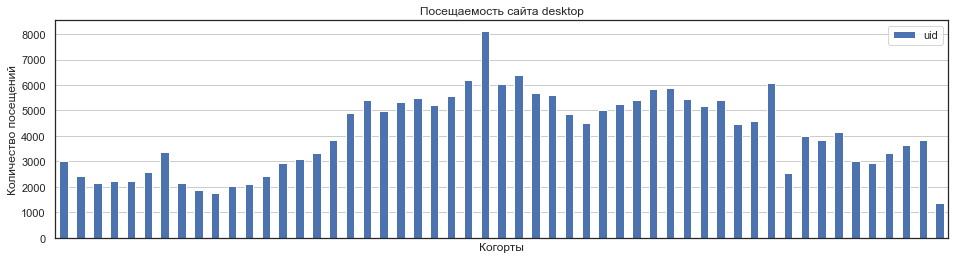

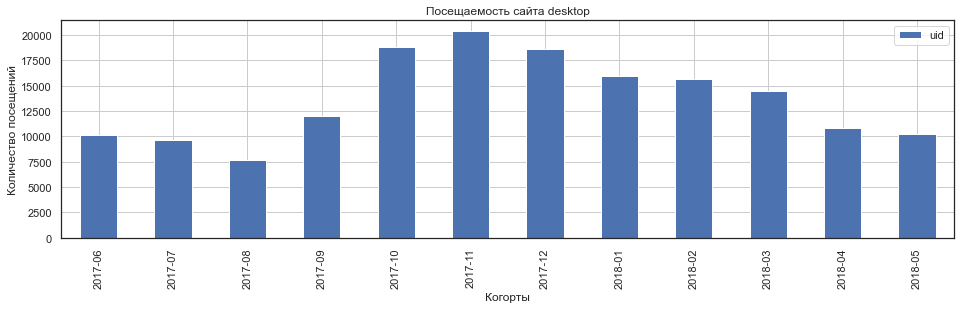

In [59]:
plot_visit(visits_daily_desktop_user,\
           visits_weekly_desktop_user,\
           visits_monthly_desktop_user,\
           'Посещаемость сайта desktop')

In [60]:
describe_visits(visits_daily_desktop_user,\
                visits_weekly_desktop_user,\
                visits_monthly_desktop_user)

,day,week,month
count,364.00,53.00,12.00
mean,659.24,4135.75,13710.25
std,284.77,1540.29,4206.94
min,1.00,1361.00,7635.00
25%,421.75,2932.00,10220.75
50%,649.00,4162.00,13240.00
75%,877.00,5403.00,16645.25
max,2605.00,8131.00,20439.00


### touch

In [61]:
visits_daily_touch_user = visits_touch.groupby('day_visits').agg({'uid':'nunique'})
visits_weekly_touch_user = visits_touch.groupby('week_visits').agg({'uid':'nunique'})
visits_monthly_touch_user = visits_touch.groupby('first_month_y_m').agg({'uid':'nunique'})

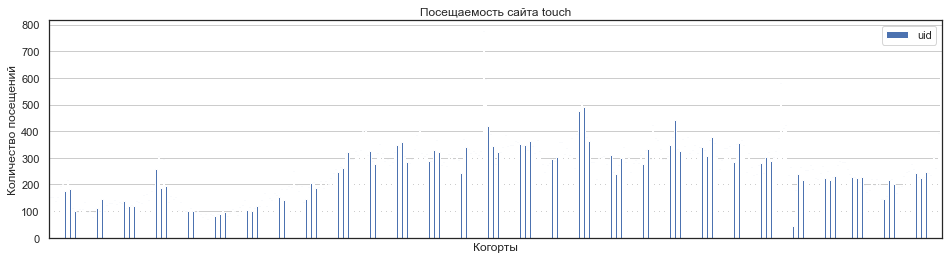

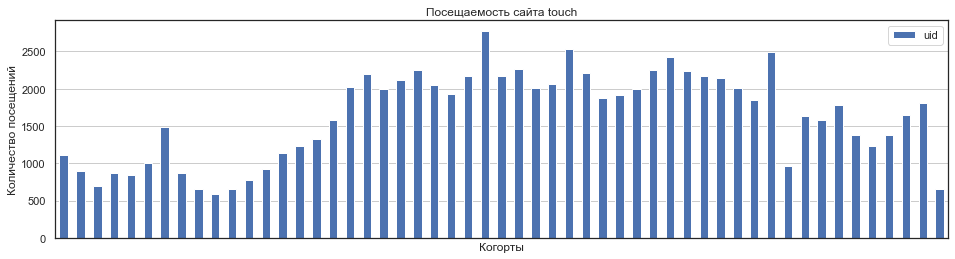

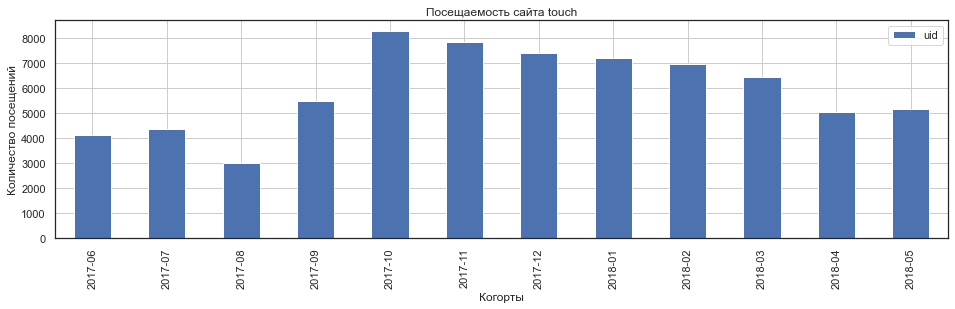

In [62]:
plot_visit(visits_daily_touch_user,\
           visits_weekly_touch_user,\
           visits_monthly_touch_user,\
           'Посещаемость сайта touch')

In [63]:
describe_visits(visits_daily_touch_user,\
                visits_weekly_touch_user,\
                visits_monthly_touch_user)

,day,week,month
count,363.00,53.00,12.00
mean,252.87,1637.26,5945.42
std,102.04,600.44,1662.45
min,46.00,586.00,3015.00
25%,173.50,1110.00,4863.25
50%,264.00,1805.00,5974.00
75%,322.00,2138.00,7260.00
max,777.00,2778.00,8299.00


Если рассматривать количество визитов по источникам, но большее количество визитов происходит с компьютера, среднее количество посещений за месяц равно 13710 против 5945 посещений с телефонов.

## Сколько сесий в день (по устройствам)

### desktop

In [64]:
count_session_desktop_day = visits_desktop.\
    groupby('day_visits')['uid'].\
    count()

count_session_desktop_day.describe()

count    364.00
mean     721.34
std      322.33
min        1.00
25%      457.25
50%      711.00
75%      961.50
max     3152.00
Name: uid, dtype: float64

### touch

In [65]:
count_session_touch_day = visits_touch.\
    groupby('day_visits')['uid'].\
    count()

count_session_touch_day.describe()

count   363.00
mean    266.76
std     110.86
min      47.00
25%     181.00
50%     278.00
75%     337.00
max     890.00
Name: uid, dtype: float64

По количеству сессий в день на компьтерах больше в среднем чем на телефонах. 721 против 266

## Сколько длится одна сесия (по устройствам)

### desktop

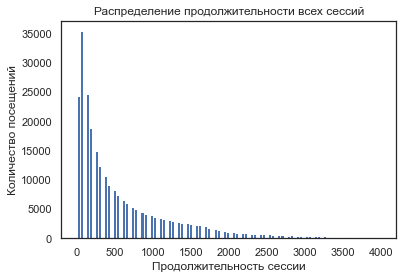

In [66]:
session_duration(visits_desktop)

In [67]:
visits_desktop['session_duration_sec'].mode()

0    60
dtype: int64

### touch

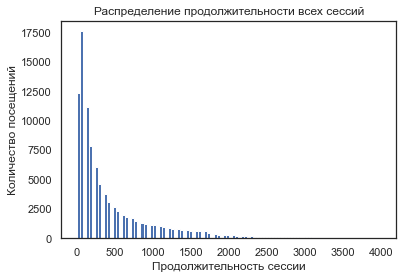

In [68]:
session_duration(visits_touch)

In [69]:
visits_touch['session_duration_sec'].mode()

0    60
dtype: int64

## Как часто люди возвращаются (по устройствам)

### desktop

In [70]:
# Сгруппируем данные по когорте first_visits_month и месяцу визита visits_month
visits_grouped_by_cohorts_desktop = visits_desktop.\
    groupby(['first_visits_month','month_visits']).\
    agg({'uid':'nunique'})

# Найдём lifetime когорты. Из visits_month вычтем месяц когорты first_visits_month

visits_grouped_by_cohorts_desktop = visits_grouped_by_cohorts_desktop.reset_index()

visits_grouped_by_cohorts_desktop['cohort_lifetime'] = (
    visits_grouped_by_cohorts_desktop['month_visits'] -
    visits_grouped_by_cohorts_desktop['first_visits_month']
)
visits_grouped_by_cohorts_desktop['cohort_lifetime'] = (
    visits_grouped_by_cohorts_desktop['cohort_lifetime'] / 
    np.timedelta64(1,'M')
)
visits_grouped_by_cohorts_desktop['cohort_lifetime'] = (
    visits_grouped_by_cohorts_desktop['cohort_lifetime'].\
    round().astype('int')
)
visits_grouped_by_cohorts_desktop['first_visits_month'] = (
    visits_grouped_by_cohorts_desktop['first_visits_month'].\
    dt.strftime('%Y-%m')
)

visits_per_user_pivot_desktop = visits_grouped_by_cohorts_desktop.\
    pivot_table(index='first_visits_month',\
                columns='cohort_lifetime',\
                values='uid',\
                aggfunc='mean')
visits_per_user_pivot_desktop.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,,
2017-06,9761.00,833.00,593.00,671.00,741.00,799.00,656.00,627.00,574.00,552.00,441.00,471.00
2017-07,9312.00,568.00,520.00,568.00,602.00,483.00,466.00,463.00,391.00,289.00,265.00,
2017-08,7450.00,603.00,492.00,504.00,406.00,349.00,279.00,302.00,234.00,218.00,,
2017-09,11715.00,1034.00,875.00,655.00,485.00,495.00,450.00,302.00,279.00,,,
2017-10,18451.00,1530.00,1015.00,740.00,681.00,646.00,423.00,413.00,,,,
2017-11,20129.00,1619.00,902.00,806.00,681.00,489.00,451.00,,,,,
2017-12,18460.00,972.00,708.00,565.00,371.00,371.00,,,,,,
2018-01,15809.00,982.00,638.00,413.00,337.00,,,,,,,
2018-02,15586.00,937.00,418.00,312.00,,,,,,,,


In [71]:
# Чтобы найти Retention Rate, нужно сперва получить число пользователей, 
# изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц
# Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю
initial_users_count_desktop = (
    visits_grouped_by_cohorts_desktop.
    loc[visits_grouped_by_cohorts_desktop['cohort_lifetime'] == 0]
    [['first_visits_month','uid']]
)

initial_users_count_desktop = initial_users_count_desktop.\
    rename(columns={'uid':'cohort_users'})

# Объединим данные по когортам с исходным количеством пользователей в когорте:
visits_grouped_by_cohorts_desktop = visits_grouped_by_cohorts_desktop.\
    merge(initial_users_count_desktop, on='first_visits_month')

# Рассчитаем Retention Rate. Разделим количество активных пользователей 
# в каждый из месяцев на исходное число пользователей в когорте
visits_grouped_by_cohorts_desktop['retention'] = (
    visits_grouped_by_cohorts_desktop['uid'] /
    visits_grouped_by_cohorts_desktop['cohort_users']
)


In [72]:
# Построим сводную таблицу 
retention_pivot_desktop = visits_grouped_by_cohorts_desktop.\
    pivot_table(index='first_visits_month',\
                columns='cohort_lifetime',\
                values='retention',\
                aggfunc='sum')

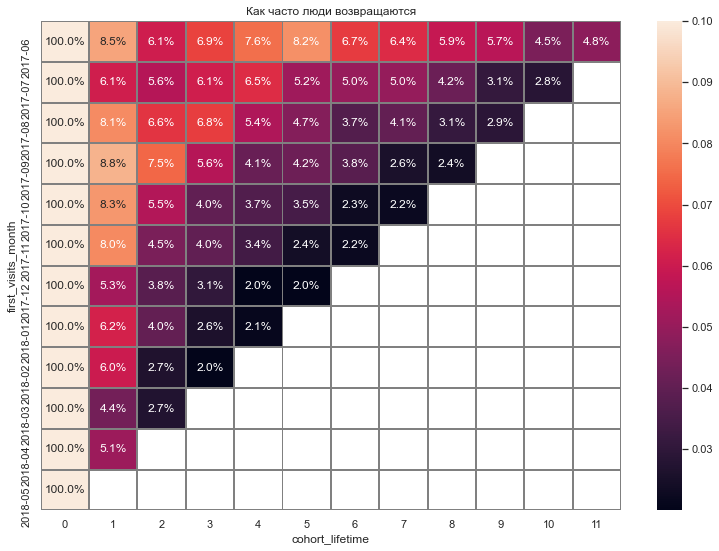

In [73]:
heatmap_retention_visits(retention_pivot_desktop)

### touch

In [74]:
# Сгруппируем данные по когорте first_visits_month и месяцу визита visits_month
visits_grouped_by_cohorts_touch = visits_touch.\
    groupby(['first_visits_month','month_visits']).\
    agg({'uid':'nunique'})

# Найдём lifetime когорты. Из visits_month вычтем месяц когорты first_visits_month

visits_grouped_by_cohorts_touch = visits_grouped_by_cohorts_touch.reset_index()

visits_grouped_by_cohorts_touch['cohort_lifetime'] = (
    visits_grouped_by_cohorts_touch['month_visits'] -
    visits_grouped_by_cohorts_touch['first_visits_month']
)
visits_grouped_by_cohorts_touch['cohort_lifetime'] = (
    visits_grouped_by_cohorts_touch['cohort_lifetime'] / 
    np.timedelta64(1,'M')
)
visits_grouped_by_cohorts_touch['cohort_lifetime'] = (
    visits_grouped_by_cohorts_touch['cohort_lifetime'].\
    round().astype('int')
)
visits_grouped_by_cohorts_touch['first_visits_month'] = (
    visits_grouped_by_cohorts_touch['first_visits_month'].\
    dt.strftime('%Y-%m')
)

visits_per_user_pivot_touch = visits_grouped_by_cohorts_touch.\
    pivot_table(index='first_visits_month',\
                columns='cohort_lifetime',\
                values='uid',\
                aggfunc='mean')
visits_per_user_pivot_touch.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,,
2017-06,3655.00,241.00,145.00,173.00,214.00,202.00,201.00,168.00,156.00,157.00,126.00,156.00
2017-07,3982.00,191.00,174.00,195.00,191.00,177.00,150.00,151.00,139.00,98.00,109.00,
2017-08,2796.00,199.00,161.00,155.00,114.00,112.00,99.00,111.00,55.00,55.00,,
2017-09,5133.00,436.00,316.00,227.00,191.00,162.00,166.00,105.00,111.00,,,
2017-10,7850.00,576.00,385.00,293.00,241.00,217.00,144.00,126.00,,,,
2017-11,7473.00,581.00,336.00,272.00,265.00,160.00,151.00,,,,,
2017-12,7100.00,473.00,273.00,237.00,143.00,120.00,,,,,,
2018-01,7018.00,410.00,272.00,158.00,130.00,,,,,,,
2018-02,6826.00,358.00,154.00,142.00,,,,,,,,


In [75]:
# Чтобы найти Retention Rate, нужно сперва получить число пользователей, 
# изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц
# Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю
initial_users_count_touch = (
    visits_grouped_by_cohorts_touch.
    loc[visits_grouped_by_cohorts_touch['cohort_lifetime'] == 0]
    [['first_visits_month','uid']]
)
initial_users_count_touch = initial_users_count_touch.\
    rename(columns={'uid':'cohort_users'})

# Объединим данные по когортам с исходным количеством пользователей в когорте:
visits_grouped_by_cohorts_touch = visits_grouped_by_cohorts_touch.\
    merge(initial_users_count_touch, on='first_visits_month')

# Рассчитаем Retention Rate. Разделим количество активных пользователей 
# в каждый из месяцев на исходное число пользователей в когорте
visits_grouped_by_cohorts_touch['retention'] = (
    visits_grouped_by_cohorts_touch['uid'] /
    visits_grouped_by_cohorts_touch['cohort_users']
)


In [76]:
# Построим сводную таблицу 
retention_pivot_touch = visits_grouped_by_cohorts_touch.\
    pivot_table(index='first_visits_month',\
                columns='cohort_lifetime',\
                values='retention',\
                aggfunc='sum')

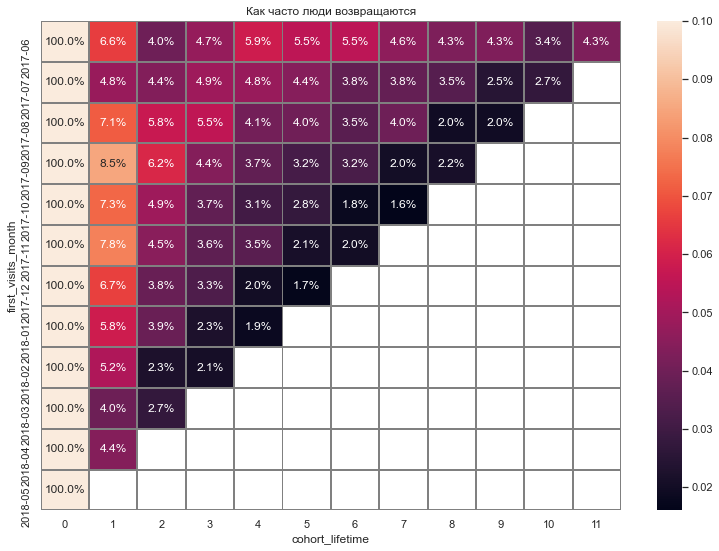

In [77]:
heatmap_retention_visits(retention_pivot_touch)

На компьтерах возвращение пользователей происходит чаще чем на телефонах.

## Когда люди начинают покупать (по устройствам)

In [78]:
session_number_desktop = session_number.query('device == "desktop"')
session_number_touch = session_number.query('device == "touch"')

## desktop

In [79]:
session_number_desktop['time_buy'].describe()

count                        29937
mean     0 days 00:10:02.158532919
std      0 days 00:14:34.480683404
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:05:00
75%                0 days 00:13:00
max                0 days 05:26:00
Name: time_buy, dtype: object

## touch

In [80]:
session_number_touch['time_buy'].describe()

count                         5990
mean     0 days 00:08:51.676126878
std      0 days 00:13:39.722714326
min                0 days 00:00:00
25%                0 days 00:01:00
50%                0 days 00:04:00
75%                0 days 00:11:00
max                0 days 04:42:00
Name: time_buy, dtype: object

На телефонах покупают быстрее,чем на компьтере. 8 минут 51 секунда против 10 минут 02 секунды.

## Сколько раз покупают за период (по устройствам)

## desktop

In [81]:
session_number_desktop['order_month'] = session_number_desktop['buy_ts'].\
    astype('datetime64[M]')

# Получим месяц первой покупки каждого покупателя
first_orders_desktop = session_number_desktop.groupby('uid').\
    agg({'order_month': 'min'}).\
    reset_index()

first_orders_desktop.columns = ['uid', 'first_order_month']

# Посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes_desktop = first_orders_desktop.\
    groupby('first_order_month').\
    agg({'uid': 'nunique'}).\
    reset_index()

cohort_sizes_desktop.columns = ['first_order_month', 'n_buyers']

# Построим когорты. 
# Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new_desktop = pd.merge(session_number_desktop,\
                              first_orders_desktop,\
                              on='uid')

# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
# Посчитаем количество покупок (coun_buy) за каждый месяц
# Сбросим индекс методом reset_index()
cohorts_desktop = orders_new_desktop.\
    groupby(['first_order_month','order_month']).\
    agg({'revenue': 'sum', 'uid' : 'count'})

cohorts_desktop = cohorts_desktop.rename(columns={'uid' : 'coun_buy'})
cohorts_desktop['count_buyers'] = orders_new_desktop.\
    groupby(['first_order_month','order_month']).\
    agg({'uid' : 'nunique'})

cohorts_desktop = cohorts_desktop.reset_index()

# С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. 
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report_desktop = pd.merge(cohort_sizes_desktop,\
                          cohorts_desktop,\
                          on='first_order_month')

report_desktop['mean_count_buy'] = (
    report_desktop['coun_buy'] /
    report_desktop['n_buyers']
)

# До расчёта LTV осталось 2 шага. Во-первых, LTV считают не из выручки, а из валовой прибыли. 
# Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. 
# Во-вторых, LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, 
# где в столбцах — не месяц заказа, а возраст (age) когорты
margin_rate = 1 
report_desktop['gp'] = report_desktop['revenue'] * margin_rate

report_desktop['age'] = (
    (report_desktop['order_month'] - report_desktop['first_order_month']) /
    np.timedelta64(1, 'M')
)
report_desktop['age'] = report_desktop['age'].round().astype('int')

output_count_buy_desktop = report_desktop.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='mean_count_buy', 
        aggfunc='mean').round(2)
    
output_count_buy_desktop = output_count_buy_desktop.cumsum(axis=1).round(2)
output_count_buy_desktop.fillna(' ')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.10,1.14,1.18,1.24,1.32,1.38,1.46,1.51,1.57,1.62,1.65,1.68
2017-07-01,1.07,1.09,1.13,1.16,1.18,1.21,1.23,1.24,1.26,1.27,1.29,
2017-08-01,1.07,1.10,1.13,1.15,1.17,1.19,1.20,1.22,1.23,1.25,,
2017-09-01,1.08,1.13,1.16,1.20,1.22,1.25,1.27,1.28,1.30,,,
2017-10-01,1.08,1.12,1.14,1.15,1.16,1.17,1.18,1.19,,,,
2017-11-01,1.09,1.13,1.15,1.17,1.18,1.19,1.21,,,,,
2017-12-01,1.09,1.14,1.18,1.21,1.22,1.24,,,,,,
2018-01-01,1.06,1.10,1.13,1.14,1.15,,,,,,,
2018-02-01,1.06,1.09,1.10,1.11,,,,,,,,


In [82]:
# output_count_buy_desktop[5].mean().round(2)

За полгода жизни когорты 1 пользователь совершает в среднем 1.23 покупки

## touch

In [83]:
session_number_touch['order_month'] = (
    session_number_touch['buy_ts'].astype('datetime64[M]')
)

# Получим месяц первой покупки каждого покупателя
first_orders_touch = session_number_touch.\
    groupby('uid').agg({'order_month': 'min'}).\
    reset_index()

first_orders_touch.columns = ['uid', 'first_order_month']

# Посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes_touch = first_orders_touch.\
    groupby('first_order_month').agg({'uid': 'nunique'}).\
    reset_index()
cohort_sizes_touch.columns = ['first_order_month', 'n_buyers']

# Построим когорты. 
# Добавим месяц первой покупки каждого покупателя в таблицу с заказами
orders_new_touch = pd.merge(session_number_touch,first_orders_touch, on='uid')

# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
# Посчитаем количество покупок (coun_buy) за каждый месяц
# Сбросим индекс методом reset_index()
cohorts_touch = orders_new_touch.groupby(['first_order_month','order_month']).\
    agg({'revenue': 'sum', 'uid' : 'count'})

cohorts_touch = cohorts_touch.rename(columns={'uid' : 'coun_buy'})

cohorts_touch['count_buyers'] = orders_new_touch.\
    groupby(['first_order_month','order_month']).agg({'uid' : 'nunique'})

cohorts_touch = cohorts_touch.reset_index()

# С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. 
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report_touch = pd.merge(cohort_sizes_touch,\
                        cohorts_touch,\
                        on='first_order_month')

report_touch['mean_count_buy'] = (
    report_touch['coun_buy'] / report_touch['n_buyers']
)

# До расчёта LTV осталось 2 шага. Во-первых, LTV считают не из выручки, а из валовой прибыли. 
# Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. 
# Во-вторых, LTV — относительный показатель. Значит его удобнее смотреть по «возрастным» когортам, 
# где в столбцах — не месяц заказа, а возраст (age) когорты
margin_rate = 1 
report_touch['gp'] = report_touch['revenue'] * margin_rate
report_touch['age'] = (
    (report_touch['order_month'] - report_touch['first_order_month']) /
    np.timedelta64(1, 'M')
)
report_touch['age'] = report_touch['age'].round().astype('int')

output_count_buy_touch = report_touch.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='mean_count_buy', 
        aggfunc='mean').round(2)
    
output_count_buy_touch = output_count_buy_touch.cumsum(axis=1).round(2)
output_count_buy_touch.fillna(' ')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.05,1.06,1.07,1.07,1.08,1.09,,,,,,1.09
2017-07-01,1.09,1.11,1.12,1.13,1.14,1.15,1.15,1.17,1.18,,1.19,
2017-08-01,1.07,1.08,1.11,1.12,,1.14,1.16,1.17,1.17,1.17,,
2017-09-01,1.06,1.10,1.12,1.14,1.15,1.16,1.17,,1.17,,,
2017-10-01,1.08,1.11,1.13,1.13,1.14,1.15,1.16,1.16,,,,
2017-11-01,1.11,1.14,1.16,1.17,1.18,1.19,1.19,,,,,
2017-12-01,1.08,1.10,1.11,1.12,1.13,1.13,,,,,,
2018-01-01,1.08,1.10,1.10,1.10,,,,,,,,
2018-02-01,1.07,1.09,1.09,,,,,,,,,


In [84]:
#output_count_buy_touch[5].mean().round(2)

За полгода жизни когорты 1 пользователь совершает в среднем 1.14 покупки

К компьютере покупают чаще чем на телефонах.

## Какой средний чек (по устройствам)

## desktop

In [85]:
orders_new_desktop['month'] = orders_new_desktop['buy_ts'].dt.strftime('%Y-%m')
mean_check_desktop = orders_new_desktop.\
    pivot_table(index='uid',\
                columns='month',\
                values='revenue',\
                aggfunc='mean')
mean_check_desktop = mean_check_desktop.mean()
mean_check_desktop

month
2017-06   3.87
2017-07   5.19
2017-08   4.67
2017-09   4.88
2017-10   4.33
2017-11   4.32
2017-12   4.30
2018-01   3.98
2018-02   4.40
2018-03   4.24
2018-04   4.42
2018-05   4.39
2018-06   3.42
dtype: float64

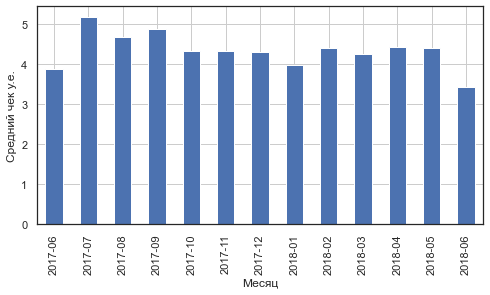

In [86]:
mean_check_data(mean_check_desktop)

In [87]:
print('Средний чек покупателя c desktop',\
      (mean_check_desktop.mean()),\
      'у.е.')

Средний чек покупателя c desktop 4.3392396568752725 у.е.


## touch

In [88]:
orders_new_touch['month'] = orders_new_touch['buy_ts'].dt.strftime('%Y-%m')
mean_check_touch = orders_new_touch.\
    pivot_table(index='uid',\
                columns='month',\
                values='revenue',\
                aggfunc='mean')
mean_check_touch = mean_check_touch.mean()
mean_check_touch

month
2017-06   3.11
2017-07   4.57
2017-08   4.18
2017-09   3.76
2017-10   4.09
2017-11   4.33
2017-12   3.39
2018-01   3.15
2018-02   3.30
2018-03   3.95
2018-04   3.65
2018-05   3.80
dtype: float64

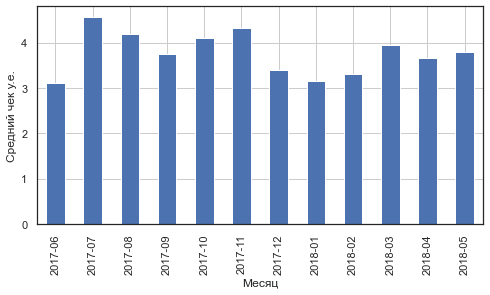

In [89]:
mean_check_data(mean_check_touch)

In [90]:
#print('Средний чек покупателя c touch', (mean_check_touch.mean()).round(2), 'у.е.')

Средний чек на компьютере больше, чем на телефоне. 4.34 против 3.77

## Сколько денег приносят (по устройствам)

## desktop

In [91]:
# Наконец, найдём LTV. Разделим валовую прибыль когорт за каждый месяц 
# на общее число пользователей в каждой когорте. 
report_desktop['ltv'] = report_desktop['gp'] / report_desktop['n_buyers']

output_ltv_desktop = report_desktop.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)

output_ltv_desktop = output_ltv_desktop.cumsum(axis=1).round(2)
output_ltv_desktop.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.48,4.68,4.89,5.32,5.70,6.08,6.76,7.03,7.32,7.78,8.12,8.20
2017-07-01,5.68,5.85,6.24,6.44,6.51,6.61,6.66,6.69,6.78,6.90,7.00,
2017-08-01,5.00,5.19,5.33,5.47,5.58,5.67,5.72,5.98,6.12,6.24,,
2017-09-01,5.48,6.01,6.26,8.78,9.25,9.64,9.95,10.08,10.19,,,
2017-10-01,4.82,5.10,5.20,5.28,5.34,5.49,5.52,5.58,,,,
2017-11-01,4.59,4.79,4.92,5.03,5.06,5.08,5.19,,,,,
2017-12-01,4.73,4.98,5.59,6.54,6.61,6.69,,,,,,
2018-01-01,4.01,4.25,4.44,4.59,4.63,,,,,,,
2018-02-01,4.02,4.14,4.19,4.21,,,,,,,,


In [94]:
#print('LTV за полгода на desktop составил',\
output_ltv_desktop[5].mean()

6.465714285714285

## touch

In [95]:
# Наконец, найдём LTV. Разделим валовую прибыль когорт за каждый месяц 
# на общее число пользователей в каждой когорте. 
report_touch['ltv'] = report_touch['gp'] / report_touch['n_buyers']

output_ltv_touch = report_touch.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)

output_ltv_touch = output_ltv_touch.cumsum(axis=1).round(2)
output_ltv_touch.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,3.21,3.24,3.32,3.34,3.39,3.42,,,,,,3.44
2017-07-01,4.92,5.06,5.07,5.12,5.15,5.17,5.17,5.20,5.21,,5.27,
2017-08-01,4.64,4.69,4.74,4.76,,4.77,4.91,4.92,4.93,4.98,,
2017-09-01,3.94,4.63,4.89,5.04,5.05,5.07,5.08,,5.08,,,
2017-10-01,4.37,4.72,4.78,4.78,4.80,4.90,4.91,4.91,,,,
2017-11-01,5.01,5.05,5.08,5.10,5.13,5.14,5.15,,,,,
2017-12-01,3.61,3.66,3.76,3.89,3.90,3.90,,,,,,
2018-01-01,3.43,3.49,3.50,3.51,,,,,,,,
2018-02-01,3.43,3.46,3.46,,,,,,,,,


In [98]:
#print('LTV за полгода на touch составил',\
output_ltv_touch[5].mean()

4.624285714285714

LTV на компьютерах так же интереснее чем на телефонах. 6.47 против 4.62

# Вывод

Проанализировав данные из трех таблиц (visits, orders, costs), можно сделать определенные выводы. Проект на данный момент убыточен, в большинстве своем из-за неправильного распределения рекламных расходов.

<AxesSubplot:title={'center':'Накопительный ROMI по каждому рекламному источнику ежемесячно'}, xlabel='month_y_m', ylabel='source_id'>

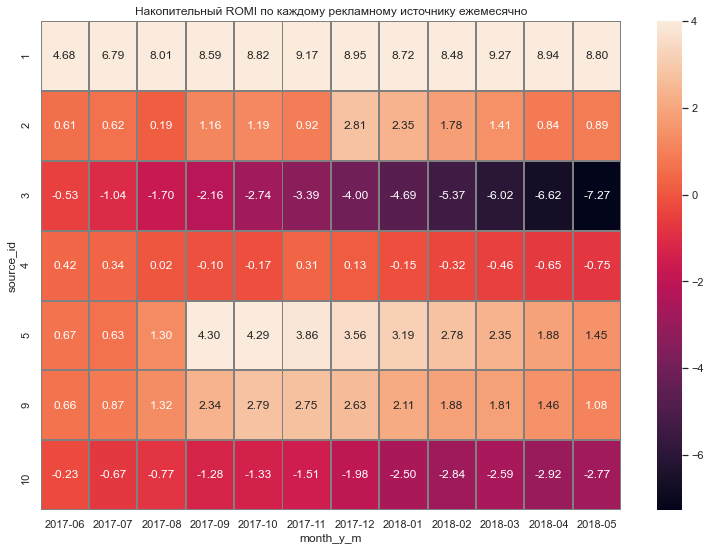

In [99]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Накопительный ROMI по каждому рекламному источнику ежемесячно')
sns.heatmap(output_roi.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmax=4)

- Из таблицы отчетливо видно яркую убыточность по третьему, четвертому и десятому рекламному источнику. На них нужно снизить расходы до минимума или вообще исключить. В большей степени стоит вложиться в рекламный источник под номером 1 на фоне остальных, он самый выгодный. В небольшой плюс сработали второй, пятый и девятый рекламные источники. Стоит помнить, что второй один из самых затратных рекламных источников.
- Также стоит больше ореинтироваться на пользователей приходящих на сайт с компьютеров, все метрики кроме скорости покупки, у них лучше.
- Стоит обратить внимание на общую посещаемость. 

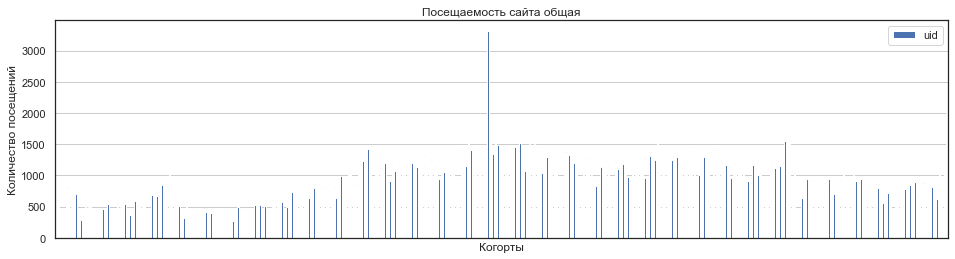

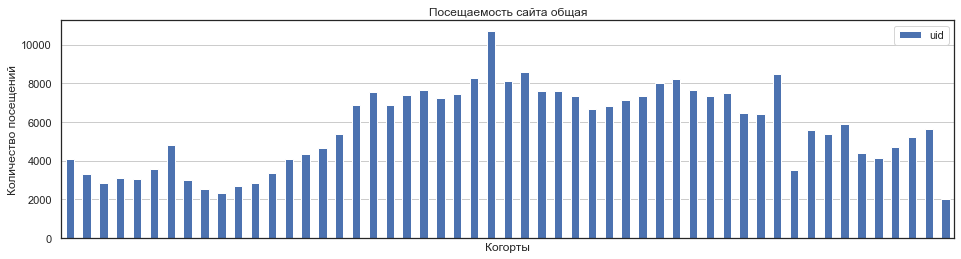

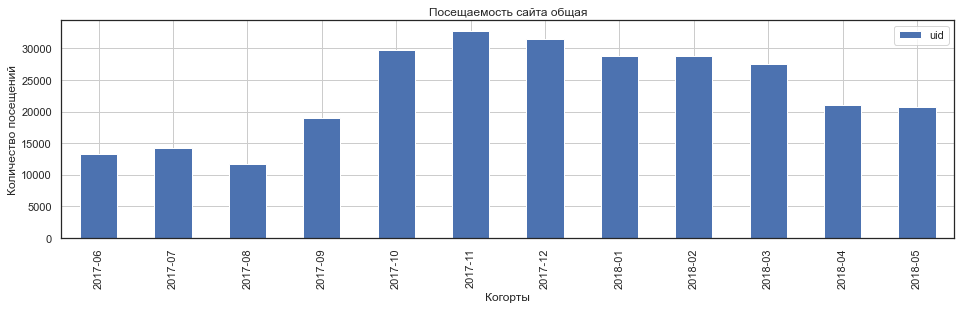

In [100]:
plot_visit(visits_daily,\
           visits_weekly,\
           visits_monthly,\
           'Посещаемость сайта общая')

По графикам видно провалы посещаемости в июне, июле и августе. Начиная с сентября идет рост визитов на сайт. Пик посещаемости приходится на ноябрь месяц, далее начинается плавное ежемесячное снижение количества визитов на сайт.

In [101]:
describe_visits(visits_daily, visits_weekly, visits_monthly)

,day,week,month
count,364.00,53.00,12.00
mean,907.99,5724.42,23228.42
std,370.51,2096.12,7546.38
min,1.00,1997.00,11631.00
25%,594.00,4056.00,17777.00
50%,921.00,5894.00,24240.50
75%,1173.00,7441.00,28984.75
max,3319.00,10716.00,32797.00


Из таблицы числового описания данных видно среднее значение посещаемости сайта (уникальных визитов). В день 907 визитов, в неделю 5724 визитов и 23228 визитов в месяц. По стандартоному отклонению видно большой разброс данных. 

Также можно обратить внимание на тепловую карту Retention Rate временных когорт.

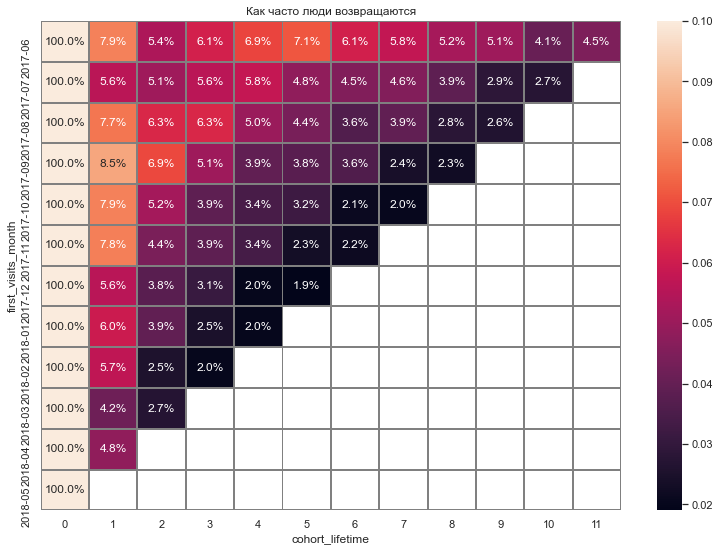

In [102]:
heatmap_retention_visits(retention_pivot)

По июньской когорте видно, что с ноября по апрель посетителей возвращается все меньше и меньше. Подобная динамика оттока повторных визитов наблюдается по всем когортам.

In [103]:
#visits.locvisits['end_ts'].dt.strftime('%Y')
data_2018 = visits.loc[visits['end_ts'].dt.year == 2018]

In [108]:
group = data_2018.groupby('first_month_y_m').agg({'session_duration_sec':'sum'})
group


,session_duration_sec
first_month_y_m,
2017-06,9524040
2017-07,2667000
2017-08,2615340
2017-09,2630640
2017-10,4003920
2017-11,6667980
2017-12,4582440
2018-01,18727949
2018-02,17160162


Text(0, 0.5, 'Количество посещений')

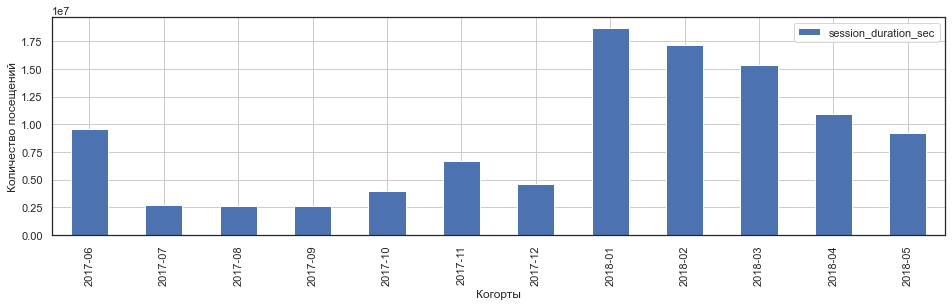

In [109]:
group.plot(y='session_duration_sec', kind='bar', figsize=(16, 4), grid=True, title = None)
 
plt.xlabel("Когорты")
plt.ylabel("Количество посещений")